In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

## Neural Network Model

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [3]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)

### Differential equation
$$\frac{d^2\phi(r)}{dr^2} + \frac{2m}{\hbar^2}\left(E-\frac{l(l+1)}{2mr^2}\hbar^2-V(r)\right)\phi(r) = 0$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\phi_t(r) = e^{-\beta r^2}N(r,\vec{p})$, with $\phi(r=0) = 0$ and $\phi(r\rightarrow\infty) = 0$ as boundary conditions.  

In [4]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=False)
  )
)

In [5]:
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0001)
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0
V = lambda r: -(Z*e**2)/r
Phi_t = lambda r: torch.exp(-beta*r**2) * model.forward(r)

In [6]:
def loss_fn(r):
    r.requires_grad = True
    
    outputs = Phi_t(r)
    Phi_t_r = torch.autograd.grad(outputs, r, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi_t = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*outputs
    
    prom = outputs.size()[0]
    
    delta = r[1]-r[0]
    norm = torch.sum(outputs**2)*delta
    
    global E
    E = (torch.sum(outputs*H_Phi_t)*delta)/norm
    
    return (torch.mean((H_Phi_t - E*outputs)**2)*prom)/norm #multiply by m to avoit division by m in the mean function of torh 

In [7]:
upper_r = 6
lower_r = 1e-2
steps = 100
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn(R_train.to(device))}")
    training(R_train, loss_fn, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: tensor([14181.8389], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([17897.5410], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([17496.9414], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([17240.5879], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([17020.6035], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([16805.1113], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([16578.7441], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([16332.2588], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([16061.3604], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([15777.2041], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([15478.1504], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([15137.9980], grad_fn=<DivBackward0>)
E

Epoch 103
 ---------------------- loss: tensor([147.7812], grad_fn=<DivBackward0>)
Epoch 104
 ---------------------- loss: tensor([147.3180], grad_fn=<DivBackward0>)
Epoch 105
 ---------------------- loss: tensor([146.9541], grad_fn=<DivBackward0>)
Epoch 106
 ---------------------- loss: tensor([146.6681], grad_fn=<DivBackward0>)
Epoch 107
 ---------------------- loss: tensor([146.4410], grad_fn=<DivBackward0>)
Epoch 108
 ---------------------- loss: tensor([146.2432], grad_fn=<DivBackward0>)
Epoch 109
 ---------------------- loss: tensor([146.0556], grad_fn=<DivBackward0>)
Epoch 110
 ---------------------- loss: tensor([145.8667], grad_fn=<DivBackward0>)
Epoch 111
 ---------------------- loss: tensor([145.6589], grad_fn=<DivBackward0>)
Epoch 112
 ---------------------- loss: tensor([145.4408], grad_fn=<DivBackward0>)
Epoch 113
 ---------------------- loss: tensor([145.0729], grad_fn=<DivBackward0>)
Epoch 114
 ---------------------- loss: tensor([144.6505], grad_fn=<DivBackward0>)
Epoc

In [8]:
E

tensor([0.6250], grad_fn=<DivBackward0>)

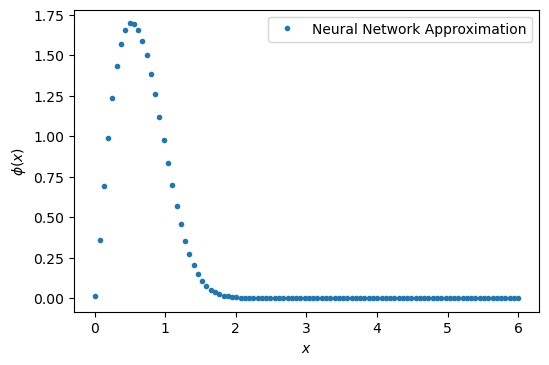

In [9]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]

with torch.no_grad():
    yy = Phi_t(torch.Tensor(rr).to(device)).cpu().numpy()
#yt = xx**2 + np.exp(-xx**2 / 2)/(1+xx+xx**3)

fig, axs = plt.subplots(dpi=100)
#axs.plot(xx, yt, label="True")
axs.plot(rr, yy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\phi(x)$")
plt.legend(loc="best")

## With Xavier initialization of parameters

In [16]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_normal_(m.weight.data)
        # if you also want for linear layers ,add one more elif condition 

In [18]:
model = NeuralNetwork().to(device)
initialize_weights(model)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0001)
upper_r = 6
lower_r = 1e-2
steps = 100
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn(R_train.to(device))}")
    training(R_train, loss_fn, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: tensor([1391.9270], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([1379.7018], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([1375.4695], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([1371.2252], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([1366.9746], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([1362.6860], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([1358.3827], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([1354.0688], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([1349.7057], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([1345.2908], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([1340.8215], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([1336.2494], grad_fn=<DivBackward0>)
Epoch 13
 ---

Epoch 101
 ---------------------- loss: tensor([100.1924], grad_fn=<DivBackward0>)
Epoch 102
 ---------------------- loss: tensor([100.0533], grad_fn=<DivBackward0>)
Epoch 103
 ---------------------- loss: tensor([99.9406], grad_fn=<DivBackward0>)
Epoch 104
 ---------------------- loss: tensor([99.7555], grad_fn=<DivBackward0>)
Epoch 105
 ---------------------- loss: tensor([99.5067], grad_fn=<DivBackward0>)
Epoch 106
 ---------------------- loss: tensor([99.4437], grad_fn=<DivBackward0>)
Epoch 107
 ---------------------- loss: tensor([99.3369], grad_fn=<DivBackward0>)
Epoch 108
 ---------------------- loss: tensor([99.2598], grad_fn=<DivBackward0>)
Epoch 109
 ---------------------- loss: tensor([99.1546], grad_fn=<DivBackward0>)
Epoch 110
 ---------------------- loss: tensor([98.9568], grad_fn=<DivBackward0>)
Epoch 111
 ---------------------- loss: tensor([98.8679], grad_fn=<DivBackward0>)
Epoch 112
 ---------------------- loss: tensor([98.7991], grad_fn=<DivBackward0>)
Epoch 113
 ---

In [19]:
E

tensor([1.1649], grad_fn=<DivBackward0>)

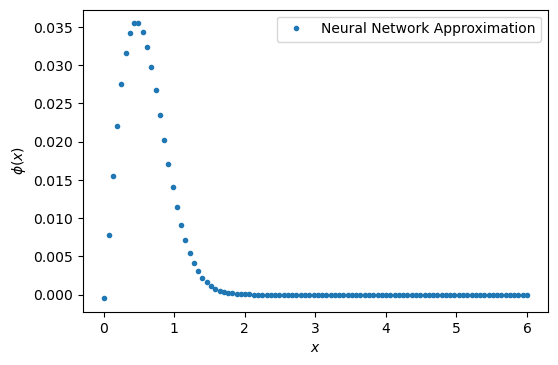

In [20]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]

with torch.no_grad():
    yy = Phi_t(torch.Tensor(rr).to(device)).cpu().numpy()
#yt = xx**2 + np.exp(-xx**2 / 2)/(1+xx+xx**3)

fig, axs = plt.subplots(dpi=100)
#axs.plot(xx, yt, label="True")
axs.plot(rr, yy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\phi(x)$")
plt.legend(loc="best")

In [46]:
upper_r = 6
lower_r = 1e-2
steps = 100
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epochs = 300
lrs = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
Phis_t = []
Es = []

for lr in lrs:
    model = NeuralNetwork().to(device)
    initialize_weights(model)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    for t in range(epochs):
        print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn(R_train.to(device))}")
        training(R_train, loss_fn, optimizer)
    print("Done!\n\n")
    Phis_t.append(Phi_t(R_train).detach().numpy())
    Es.append(E)

Epoch 1
 ---------------------- loss: tensor([16123.1299], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([14351.2256], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([9189.5664], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([17826.1875], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([757.8359], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([534.0950], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([515.5474], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([366.2880], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([330.3906], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([318.8073], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([302.4662], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([293.5590], grad_fn=<DivBackward0>)
Epoch 13
 --------

Epoch 103
 ---------------------- loss: tensor([0.0550], grad_fn=<DivBackward0>)
Epoch 104
 ---------------------- loss: tensor([0.0520], grad_fn=<DivBackward0>)
Epoch 105
 ---------------------- loss: tensor([0.0489], grad_fn=<DivBackward0>)
Epoch 106
 ---------------------- loss: tensor([0.0486], grad_fn=<DivBackward0>)
Epoch 107
 ---------------------- loss: tensor([0.0459], grad_fn=<DivBackward0>)
Epoch 108
 ---------------------- loss: tensor([0.0430], grad_fn=<DivBackward0>)
Epoch 109
 ---------------------- loss: tensor([0.3362], grad_fn=<DivBackward0>)
Epoch 110
 ---------------------- loss: tensor([0.0513], grad_fn=<DivBackward0>)
Epoch 111
 ---------------------- loss: tensor([0.0364], grad_fn=<DivBackward0>)
Epoch 112
 ---------------------- loss: tensor([0.0352], grad_fn=<DivBackward0>)
Epoch 113
 ---------------------- loss: tensor([0.0336], grad_fn=<DivBackward0>)
Epoch 114
 ---------------------- loss: tensor([0.0348], grad_fn=<DivBackward0>)
Epoch 115
 -----------------

Epoch 244
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 245
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 246
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 247
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 248
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 249
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 250
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 251
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 252
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 253
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 254
 ---------------------- loss: tensor([19809.6270], grad_fn=<DivBackward0>)
Epoch 255
 ---------------------- loss: tensor([19809.6270], grad

Epoch 44
 ---------------------- loss: tensor([28219.6406], grad_fn=<DivBackward0>)
Epoch 45
 ---------------------- loss: tensor([28219.5020], grad_fn=<DivBackward0>)
Epoch 46
 ---------------------- loss: tensor([28219.2695], grad_fn=<DivBackward0>)
Epoch 47
 ---------------------- loss: tensor([28219.2090], grad_fn=<DivBackward0>)
Epoch 48
 ---------------------- loss: tensor([28218.9863], grad_fn=<DivBackward0>)
Epoch 49
 ---------------------- loss: tensor([28218.7598], grad_fn=<DivBackward0>)
Epoch 50
 ---------------------- loss: tensor([28218.5312], grad_fn=<DivBackward0>)
Epoch 51
 ---------------------- loss: tensor([28218.5176], grad_fn=<DivBackward0>)
Epoch 52
 ---------------------- loss: tensor([28218.4824], grad_fn=<DivBackward0>)
Epoch 53
 ---------------------- loss: tensor([28218.2539], grad_fn=<DivBackward0>)
Epoch 54
 ---------------------- loss: tensor([28218.0996], grad_fn=<DivBackward0>)
Epoch 55
 ---------------------- loss: tensor([28217.8770], grad_fn=<DivBack

Epoch 143
 ---------------------- loss: tensor([28202.3633], grad_fn=<DivBackward0>)
Epoch 144
 ---------------------- loss: tensor([28202.1348], grad_fn=<DivBackward0>)
Epoch 145
 ---------------------- loss: tensor([28201.9102], grad_fn=<DivBackward0>)
Epoch 146
 ---------------------- loss: tensor([28201.6777], grad_fn=<DivBackward0>)
Epoch 147
 ---------------------- loss: tensor([28201.4492], grad_fn=<DivBackward0>)
Epoch 148
 ---------------------- loss: tensor([28201.2227], grad_fn=<DivBackward0>)
Epoch 149
 ---------------------- loss: tensor([28200.9980], grad_fn=<DivBackward0>)
Epoch 150
 ---------------------- loss: tensor([28200.8594], grad_fn=<DivBackward0>)
Epoch 151
 ---------------------- loss: tensor([28200.6309], grad_fn=<DivBackward0>)
Epoch 152
 ---------------------- loss: tensor([28200.4766], grad_fn=<DivBackward0>)
Epoch 153
 ---------------------- loss: tensor([28200.2461], grad_fn=<DivBackward0>)
Epoch 154
 ---------------------- loss: tensor([28200.2188], grad

Epoch 242
 ---------------------- loss: tensor([28182.6914], grad_fn=<DivBackward0>)
Epoch 243
 ---------------------- loss: tensor([28182.4473], grad_fn=<DivBackward0>)
Epoch 244
 ---------------------- loss: tensor([28182.1992], grad_fn=<DivBackward0>)
Epoch 245
 ---------------------- loss: tensor([28181.9727], grad_fn=<DivBackward0>)
Epoch 246
 ---------------------- loss: tensor([28181.7324], grad_fn=<DivBackward0>)
Epoch 247
 ---------------------- loss: tensor([28181.4902], grad_fn=<DivBackward0>)
Epoch 248
 ---------------------- loss: tensor([28181.2500], grad_fn=<DivBackward0>)
Epoch 249
 ---------------------- loss: tensor([28181.0117], grad_fn=<DivBackward0>)
Epoch 250
 ---------------------- loss: tensor([28180.7734], grad_fn=<DivBackward0>)
Epoch 251
 ---------------------- loss: tensor([28180.5352], grad_fn=<DivBackward0>)
Epoch 252
 ---------------------- loss: tensor([28180.3066], grad_fn=<DivBackward0>)
Epoch 253
 ---------------------- loss: tensor([28180.0586], grad

Epoch 41
 ---------------------- loss: tensor([27.0630], grad_fn=<DivBackward0>)
Epoch 42
 ---------------------- loss: tensor([26.1447], grad_fn=<DivBackward0>)
Epoch 43
 ---------------------- loss: tensor([25.7046], grad_fn=<DivBackward0>)
Epoch 44
 ---------------------- loss: tensor([25.3070], grad_fn=<DivBackward0>)
Epoch 45
 ---------------------- loss: tensor([24.9462], grad_fn=<DivBackward0>)
Epoch 46
 ---------------------- loss: tensor([29.2168], grad_fn=<DivBackward0>)
Epoch 47
 ---------------------- loss: tensor([27.8525], grad_fn=<DivBackward0>)
Epoch 48
 ---------------------- loss: tensor([26.7458], grad_fn=<DivBackward0>)
Epoch 49
 ---------------------- loss: tensor([25.9129], grad_fn=<DivBackward0>)
Epoch 50
 ---------------------- loss: tensor([25.2804], grad_fn=<DivBackward0>)
Epoch 51
 ---------------------- loss: tensor([24.8003], grad_fn=<DivBackward0>)
Epoch 52
 ---------------------- loss: tensor([24.5110], grad_fn=<DivBackward0>)
Epoch 53
 ------------------

Epoch 148
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 149
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 150
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 151
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 152
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 153
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 154
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 155
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 156
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 157
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 158
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 159
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 160
 -----

Epoch 262
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 263
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 264
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 265
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 266
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 267
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 268
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 269
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 270
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 271
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 272
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 273
 ---------------------- loss: tensor([24.1547], grad_fn=<DivBackward0>)
Epoch 274
 -----

Epoch 65
 ---------------------- loss: tensor([13.3420], grad_fn=<DivBackward0>)
Epoch 66
 ---------------------- loss: tensor([13.2977], grad_fn=<DivBackward0>)
Epoch 67
 ---------------------- loss: tensor([13.2243], grad_fn=<DivBackward0>)
Epoch 68
 ---------------------- loss: tensor([13.1919], grad_fn=<DivBackward0>)
Epoch 69
 ---------------------- loss: tensor([13.1657], grad_fn=<DivBackward0>)
Epoch 70
 ---------------------- loss: tensor([13.1420], grad_fn=<DivBackward0>)
Epoch 71
 ---------------------- loss: tensor([13.1245], grad_fn=<DivBackward0>)
Epoch 72
 ---------------------- loss: tensor([13.1090], grad_fn=<DivBackward0>)
Epoch 73
 ---------------------- loss: tensor([13.0937], grad_fn=<DivBackward0>)
Epoch 74
 ---------------------- loss: tensor([13.0737], grad_fn=<DivBackward0>)
Epoch 75
 ---------------------- loss: tensor([13.0530], grad_fn=<DivBackward0>)
Epoch 76
 ---------------------- loss: tensor([13.0463], grad_fn=<DivBackward0>)
Epoch 77
 ------------------

Epoch 167
 ---------------------- loss: tensor([10.6277], grad_fn=<DivBackward0>)
Epoch 168
 ---------------------- loss: tensor([10.5222], grad_fn=<DivBackward0>)
Epoch 169
 ---------------------- loss: tensor([10.4412], grad_fn=<DivBackward0>)
Epoch 170
 ---------------------- loss: tensor([10.3592], grad_fn=<DivBackward0>)
Epoch 171
 ---------------------- loss: tensor([10.3587], grad_fn=<DivBackward0>)
Epoch 172
 ---------------------- loss: tensor([10.2503], grad_fn=<DivBackward0>)
Epoch 173
 ---------------------- loss: tensor([10.1199], grad_fn=<DivBackward0>)
Epoch 174
 ---------------------- loss: tensor([10.1141], grad_fn=<DivBackward0>)
Epoch 175
 ---------------------- loss: tensor([10.1032], grad_fn=<DivBackward0>)
Epoch 176
 ---------------------- loss: tensor([10.1039], grad_fn=<DivBackward0>)
Epoch 177
 ---------------------- loss: tensor([10.1027], grad_fn=<DivBackward0>)
Epoch 178
 ---------------------- loss: tensor([10.0737], grad_fn=<DivBackward0>)
Epoch 179
 -----

Epoch 269
 ---------------------- loss: tensor([13.3646], grad_fn=<DivBackward0>)
Epoch 270
 ---------------------- loss: tensor([13.3567], grad_fn=<DivBackward0>)
Epoch 271
 ---------------------- loss: tensor([13.3524], grad_fn=<DivBackward0>)
Epoch 272
 ---------------------- loss: tensor([13.3483], grad_fn=<DivBackward0>)
Epoch 273
 ---------------------- loss: tensor([29163.6191], grad_fn=<DivBackward0>)
Epoch 274
 ---------------------- loss: tensor([18184.1250], grad_fn=<DivBackward0>)
Epoch 275
 ---------------------- loss: tensor([18183.8105], grad_fn=<DivBackward0>)
Epoch 276
 ---------------------- loss: tensor([18183.4961], grad_fn=<DivBackward0>)
Epoch 277
 ---------------------- loss: tensor([18183.1816], grad_fn=<DivBackward0>)
Epoch 278
 ---------------------- loss: tensor([18182.8633], grad_fn=<DivBackward0>)
Epoch 279
 ---------------------- loss: tensor([18182.5469], grad_fn=<DivBackward0>)
Epoch 280
 ---------------------- loss: tensor([18182.2305], grad_fn=<DivBack

Epoch 70
 ---------------------- loss: tensor([66.9750], grad_fn=<DivBackward0>)
Epoch 71
 ---------------------- loss: tensor([66.9403], grad_fn=<DivBackward0>)
Epoch 72
 ---------------------- loss: tensor([66.8304], grad_fn=<DivBackward0>)
Epoch 73
 ---------------------- loss: tensor([66.6648], grad_fn=<DivBackward0>)
Epoch 74
 ---------------------- loss: tensor([66.3411], grad_fn=<DivBackward0>)
Epoch 75
 ---------------------- loss: tensor([66.0598], grad_fn=<DivBackward0>)
Epoch 76
 ---------------------- loss: tensor([65.8531], grad_fn=<DivBackward0>)
Epoch 77
 ---------------------- loss: tensor([65.6548], grad_fn=<DivBackward0>)
Epoch 78
 ---------------------- loss: tensor([65.4598], grad_fn=<DivBackward0>)
Epoch 79
 ---------------------- loss: tensor([65.2643], grad_fn=<DivBackward0>)
Epoch 80
 ---------------------- loss: tensor([65.0689], grad_fn=<DivBackward0>)
Epoch 81
 ---------------------- loss: tensor([64.8799], grad_fn=<DivBackward0>)
Epoch 82
 ------------------

Epoch 172
 ---------------------- loss: tensor([139.5553], grad_fn=<DivBackward0>)
Epoch 173
 ---------------------- loss: tensor([136.9473], grad_fn=<DivBackward0>)
Epoch 174
 ---------------------- loss: tensor([133.7009], grad_fn=<DivBackward0>)
Epoch 175
 ---------------------- loss: tensor([131.6056], grad_fn=<DivBackward0>)
Epoch 176
 ---------------------- loss: tensor([130.1173], grad_fn=<DivBackward0>)
Epoch 177
 ---------------------- loss: tensor([128.9668], grad_fn=<DivBackward0>)
Epoch 178
 ---------------------- loss: tensor([128.0188], grad_fn=<DivBackward0>)
Epoch 179
 ---------------------- loss: tensor([127.1557], grad_fn=<DivBackward0>)
Epoch 180
 ---------------------- loss: tensor([126.3695], grad_fn=<DivBackward0>)
Epoch 181
 ---------------------- loss: tensor([125.7065], grad_fn=<DivBackward0>)
Epoch 182
 ---------------------- loss: tensor([125.1800], grad_fn=<DivBackward0>)
Epoch 183
 ---------------------- loss: tensor([124.7548], grad_fn=<DivBackward0>)
Epoc

Epoch 274
 ---------------------- loss: tensor([1814.5370], grad_fn=<DivBackward0>)
Epoch 275
 ---------------------- loss: tensor([1726.7644], grad_fn=<DivBackward0>)
Epoch 276
 ---------------------- loss: tensor([1651.7538], grad_fn=<DivBackward0>)
Epoch 277
 ---------------------- loss: tensor([1583.2203], grad_fn=<DivBackward0>)
Epoch 278
 ---------------------- loss: tensor([1519.9819], grad_fn=<DivBackward0>)
Epoch 279
 ---------------------- loss: tensor([1410.7618], grad_fn=<DivBackward0>)
Epoch 280
 ---------------------- loss: tensor([1306.6688], grad_fn=<DivBackward0>)
Epoch 281
 ---------------------- loss: tensor([1271.6042], grad_fn=<DivBackward0>)
Epoch 282
 ---------------------- loss: tensor([1241.9430], grad_fn=<DivBackward0>)
Epoch 283
 ---------------------- loss: tensor([1211.2339], grad_fn=<DivBackward0>)
Epoch 284
 ---------------------- loss: tensor([1181.8718], grad_fn=<DivBackward0>)
Epoch 285
 ---------------------- loss: tensor([1153.9539], grad_fn=<DivBack

Epoch 74
 ---------------------- loss: tensor([67.0166], grad_fn=<DivBackward0>)
Epoch 75
 ---------------------- loss: tensor([66.8594], grad_fn=<DivBackward0>)
Epoch 76
 ---------------------- loss: tensor([66.7348], grad_fn=<DivBackward0>)
Epoch 77
 ---------------------- loss: tensor([66.6431], grad_fn=<DivBackward0>)
Epoch 78
 ---------------------- loss: tensor([66.5644], grad_fn=<DivBackward0>)
Epoch 79
 ---------------------- loss: tensor([66.4901], grad_fn=<DivBackward0>)
Epoch 80
 ---------------------- loss: tensor([66.4298], grad_fn=<DivBackward0>)
Epoch 81
 ---------------------- loss: tensor([66.3849], grad_fn=<DivBackward0>)
Epoch 82
 ---------------------- loss: tensor([66.3505], grad_fn=<DivBackward0>)
Epoch 83
 ---------------------- loss: tensor([66.3006], grad_fn=<DivBackward0>)
Epoch 84
 ---------------------- loss: tensor([66.2701], grad_fn=<DivBackward0>)
Epoch 85
 ---------------------- loss: tensor([66.2433], grad_fn=<DivBackward0>)
Epoch 86
 ------------------

Epoch 176
 ---------------------- loss: tensor([150.5105], grad_fn=<DivBackward0>)
Epoch 177
 ---------------------- loss: tensor([147.7946], grad_fn=<DivBackward0>)
Epoch 178
 ---------------------- loss: tensor([144.6531], grad_fn=<DivBackward0>)
Epoch 179
 ---------------------- loss: tensor([140.9230], grad_fn=<DivBackward0>)
Epoch 180
 ---------------------- loss: tensor([134.1291], grad_fn=<DivBackward0>)
Epoch 181
 ---------------------- loss: tensor([122.8011], grad_fn=<DivBackward0>)
Epoch 182
 ---------------------- loss: tensor([113.7968], grad_fn=<DivBackward0>)
Epoch 183
 ---------------------- loss: tensor([107.5130], grad_fn=<DivBackward0>)
Epoch 184
 ---------------------- loss: tensor([102.8179], grad_fn=<DivBackward0>)
Epoch 185
 ---------------------- loss: tensor([98.9038], grad_fn=<DivBackward0>)
Epoch 186
 ---------------------- loss: tensor([94.7193], grad_fn=<DivBackward0>)
Epoch 187
 ---------------------- loss: tensor([90.2322], grad_fn=<DivBackward0>)
Epoch 1

Epoch 277
 ---------------------- loss: tensor([62.7339], grad_fn=<DivBackward0>)
Epoch 278
 ---------------------- loss: tensor([62.7200], grad_fn=<DivBackward0>)
Epoch 279
 ---------------------- loss: tensor([62.7085], grad_fn=<DivBackward0>)
Epoch 280
 ---------------------- loss: tensor([62.7003], grad_fn=<DivBackward0>)
Epoch 281
 ---------------------- loss: tensor([62.6848], grad_fn=<DivBackward0>)
Epoch 282
 ---------------------- loss: tensor([62.6775], grad_fn=<DivBackward0>)
Epoch 283
 ---------------------- loss: tensor([62.6764], grad_fn=<DivBackward0>)
Epoch 284
 ---------------------- loss: tensor([62.6692], grad_fn=<DivBackward0>)
Epoch 285
 ---------------------- loss: tensor([62.6325], grad_fn=<DivBackward0>)
Epoch 286
 ---------------------- loss: tensor([62.6302], grad_fn=<DivBackward0>)
Epoch 287
 ---------------------- loss: tensor([62.6155], grad_fn=<DivBackward0>)
Epoch 288
 ---------------------- loss: tensor([62.6097], grad_fn=<DivBackward0>)
Epoch 289
 -----

Epoch 76
 ---------------------- loss: tensor([1865.9180], grad_fn=<DivBackward0>)
Epoch 77
 ---------------------- loss: tensor([1836.9052], grad_fn=<DivBackward0>)
Epoch 78
 ---------------------- loss: tensor([1810.5243], grad_fn=<DivBackward0>)
Epoch 79
 ---------------------- loss: tensor([1788.0798], grad_fn=<DivBackward0>)
Epoch 80
 ---------------------- loss: tensor([1763.9028], grad_fn=<DivBackward0>)
Epoch 81
 ---------------------- loss: tensor([1734.4391], grad_fn=<DivBackward0>)
Epoch 82
 ---------------------- loss: tensor([1708.9874], grad_fn=<DivBackward0>)
Epoch 83
 ---------------------- loss: tensor([1673.3651], grad_fn=<DivBackward0>)
Epoch 84
 ---------------------- loss: tensor([1492.5186], grad_fn=<DivBackward0>)
Epoch 85
 ---------------------- loss: tensor([1298.7585], grad_fn=<DivBackward0>)
Epoch 86
 ---------------------- loss: tensor([1263.8687], grad_fn=<DivBackward0>)
Epoch 87
 ---------------------- loss: tensor([1237.6327], grad_fn=<DivBackward0>)
Epoc

Epoch 175
 ---------------------- loss: tensor([93.6681], grad_fn=<DivBackward0>)
Epoch 176
 ---------------------- loss: tensor([93.2086], grad_fn=<DivBackward0>)
Epoch 177
 ---------------------- loss: tensor([92.6982], grad_fn=<DivBackward0>)
Epoch 178
 ---------------------- loss: tensor([92.1958], grad_fn=<DivBackward0>)
Epoch 179
 ---------------------- loss: tensor([91.7682], grad_fn=<DivBackward0>)
Epoch 180
 ---------------------- loss: tensor([91.3888], grad_fn=<DivBackward0>)
Epoch 181
 ---------------------- loss: tensor([90.9853], grad_fn=<DivBackward0>)
Epoch 182
 ---------------------- loss: tensor([90.6276], grad_fn=<DivBackward0>)
Epoch 183
 ---------------------- loss: tensor([90.2826], grad_fn=<DivBackward0>)
Epoch 184
 ---------------------- loss: tensor([89.8094], grad_fn=<DivBackward0>)
Epoch 185
 ---------------------- loss: tensor([89.3370], grad_fn=<DivBackward0>)
Epoch 186
 ---------------------- loss: tensor([88.9455], grad_fn=<DivBackward0>)
Epoch 187
 -----

Epoch 277
 ---------------------- loss: tensor([43.8533], grad_fn=<DivBackward0>)
Epoch 278
 ---------------------- loss: tensor([43.3902], grad_fn=<DivBackward0>)
Epoch 279
 ---------------------- loss: tensor([43.0256], grad_fn=<DivBackward0>)
Epoch 280
 ---------------------- loss: tensor([42.6976], grad_fn=<DivBackward0>)
Epoch 281
 ---------------------- loss: tensor([42.3306], grad_fn=<DivBackward0>)
Epoch 282
 ---------------------- loss: tensor([41.9517], grad_fn=<DivBackward0>)
Epoch 283
 ---------------------- loss: tensor([41.5079], grad_fn=<DivBackward0>)
Epoch 284
 ---------------------- loss: tensor([41.0726], grad_fn=<DivBackward0>)
Epoch 285
 ---------------------- loss: tensor([40.6518], grad_fn=<DivBackward0>)
Epoch 286
 ---------------------- loss: tensor([40.2260], grad_fn=<DivBackward0>)
Epoch 287
 ---------------------- loss: tensor([39.8163], grad_fn=<DivBackward0>)
Epoch 288
 ---------------------- loss: tensor([39.4241], grad_fn=<DivBackward0>)
Epoch 289
 -----

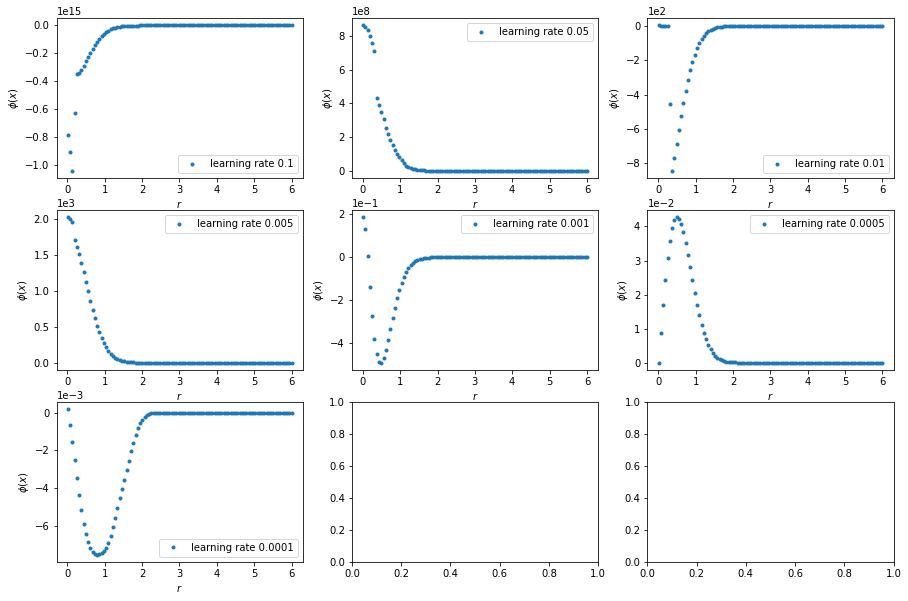

In [47]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]
fig, axs = plt.subplots(3,3,figsize=(15,10))

fil = 0
col = 0
for i in range(len(Es)):
    yy = Phis_t[i]
    axs[fil,col].plot(rr, yy.squeeze(), ".", label=f"learning rate {lrs[i]}")
    axs[fil,col].set_xlabel("$r$")
    axs[fil,col].set_ylabel("$\phi(x)$")
    axs[fil,col].legend(loc="best")
    axs[fil,col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if col == 2:
       col = 0
       fil = fil+1
    else:
       col = col+1
plt.show()        

In [48]:
Es

[tensor([-22.1364], grad_fn=<DivBackward0>),
 tensor([-19.8373], grad_fn=<DivBackward0>),
 tensor([-2.4084], grad_fn=<DivBackward0>),
 tensor([-18.4017], grad_fn=<DivBackward0>),
 tensor([3.9739], grad_fn=<DivBackward0>),
 tensor([0.8456], grad_fn=<DivBackward0>),
 tensor([-0.0149], grad_fn=<DivBackward0>)]